<div style="text-align: center; margin: auto; background:#b4cc3d; padding:10px; color:white; font-family:Calibri ;">
    <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTaJWG7PzF3toxaRMB1-JicpqMgJuEXATd0fg&" style="width:120px; padding-top: 20px;">
    <h1  style="font-size:2.8rem">Data Mining Project: ABCDEats Customer Data</h1>
    <h2  style="font-size:2rem">Value Based Segmentation</h2>
    <p style='font-size:1.2rem;'>NOVA Information Management School </p>    
    <p style='font-size:1.2rem;'>Master in Data Science and Advanced Analytics</p>    
    <img src="https://cdni.iconscout.com/illustration/premium/thumb/food-delivery-service-by-scooter-illustration-download-in-svg-png-gif-file-formats--on-pack-e-commerce-shopping-illustrations-4403764.png" style="width:33rem;">
    <p style='font-size:1.3rem; padding:0; margin:0; font-weight:bold;'>Group 41 members:</p>
    <ul style='font-size:1.2rem; list-style-position: inside; padding-left:0; border:none;'>
        <li>Elcano Gaspar (20241021)</li>
        <li>Gasper Pereira (20230984)</li>
        <li>Pedro Costa (20222121)</li>
        <li>Rita Wang (20240551)</li>
    </ul> 
    <br>
    <p style='font-size:1.2rem; '>      Fall/Spring Semester 2024-2025</p>
</div>

<h1>0. Imports and Dataset Loading</h1>

In [8]:
# !pip install minisom
# !pip install minisom --upgrade
# !pip install sns --upgrade
#!pip install --upgrade pip setuptools wheel

In [147]:
import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as GridSpec
import warnings

from itertools import combinations
from collections import Counter


from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler


from functions import * 

from scipy.stats import skew
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering


from minisom import MiniSom
from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib import colors as mpl_colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth
from sklearn.metrics import silhouette_score, silhouette_samples
from matplotlib import cm


In [148]:
df = pd.read_csv("PREPROCESSED_DATASET.csv")

# Features selected for Value-Behavior

In [149]:
value_cols = ['total_spent_log',
                'total_orders_log',
                'spend_per_vendor_log',
                "total_spent_chain_log"]

In [150]:
df[value_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
total_spent_log,30405.0,0.595231,0.133724,0.0,0.509930,0.600280,0.685081,1.0
total_orders_log,30405.0,0.268843,0.216985,0.0,0.155787,0.266320,0.422107,1.0
spend_per_vendor_log,30405.0,0.498925,0.153226,0.0,0.389090,0.500393,0.611979,1.0
total_spent_chain_log,30405.0,0.425208,0.241552,0.0,0.331481,0.474843,0.592358,1.0


In [151]:
missing_data(df[value_cols])

,Missing Count,Missing %


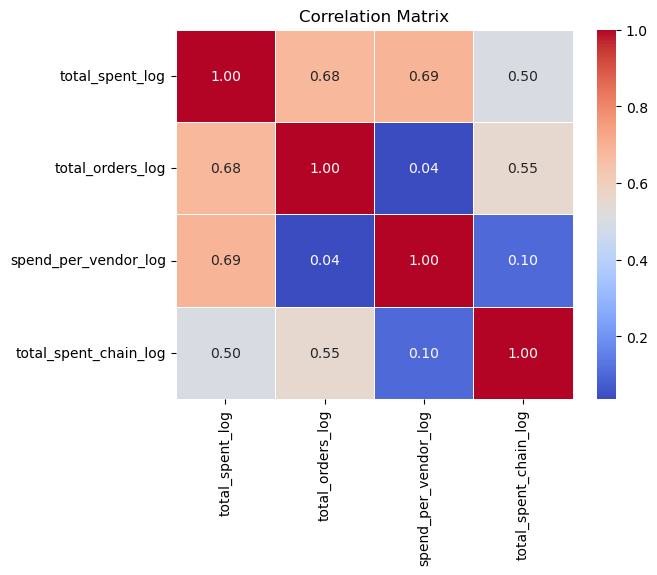

In [152]:

sns.heatmap(df[value_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


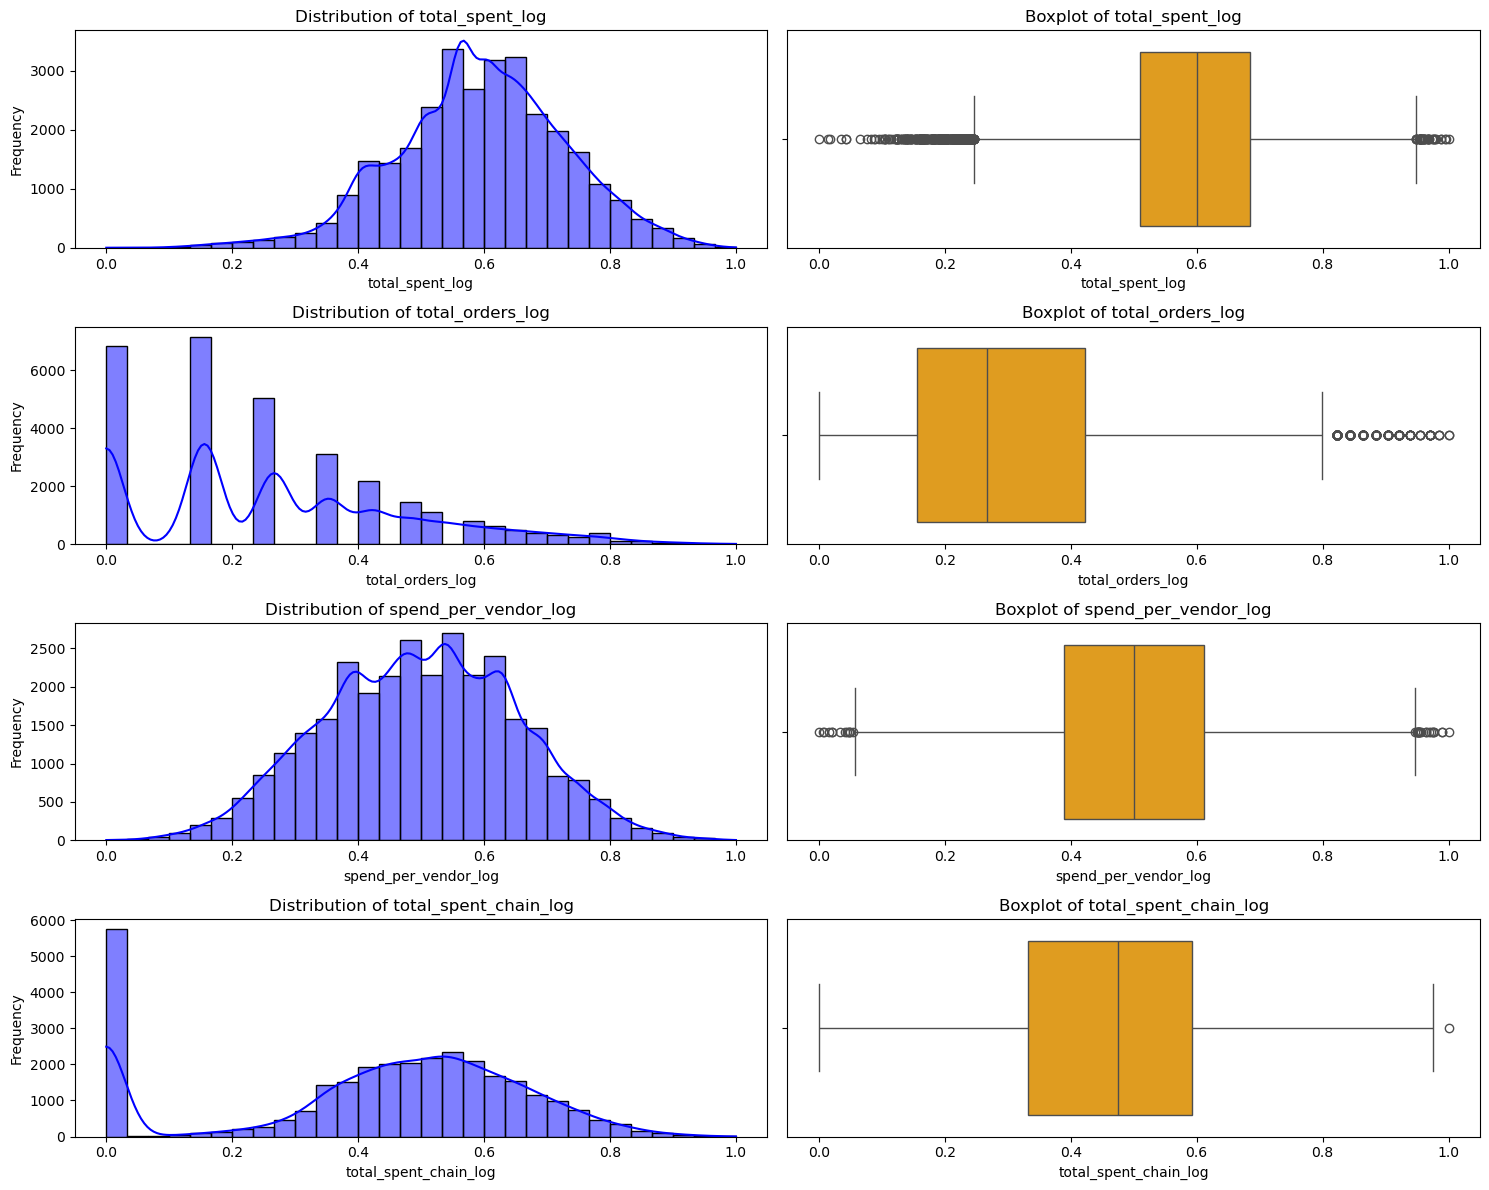

In [153]:
plot_distribution_and_boxplot(df, value_cols)

# Hierarchical Clustering

C:\Users\gaspa\AppData\Local\Temp\ipykernel_35196\1542066649.py:12: UserWarning: The markers list has more values (4) than needed (3), which may not be intended.
  sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)


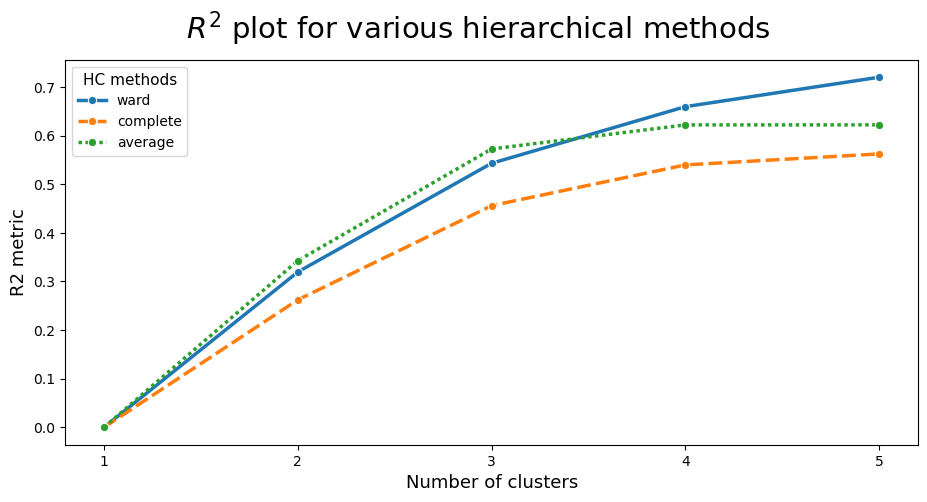

In [154]:
hc_methods = ["ward", "complete", "average"] #single
max_nclus = 5
r2_hc = np.vstack([ get_r2_hc(df[value_cols],
                              link,
                              max_nclus=max_nclus,
                              min_nclus=1,
                              dist="euclidean")
                              for link in hc_methods])

r2_hc_methods = pd.DataFrame(r2_hc.T, index=range(1, max_nclus + 1), columns=hc_methods)
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)
fig.suptitle("$R^2$ plot for various hierarchical methods", fontsize=21)
plt.show()


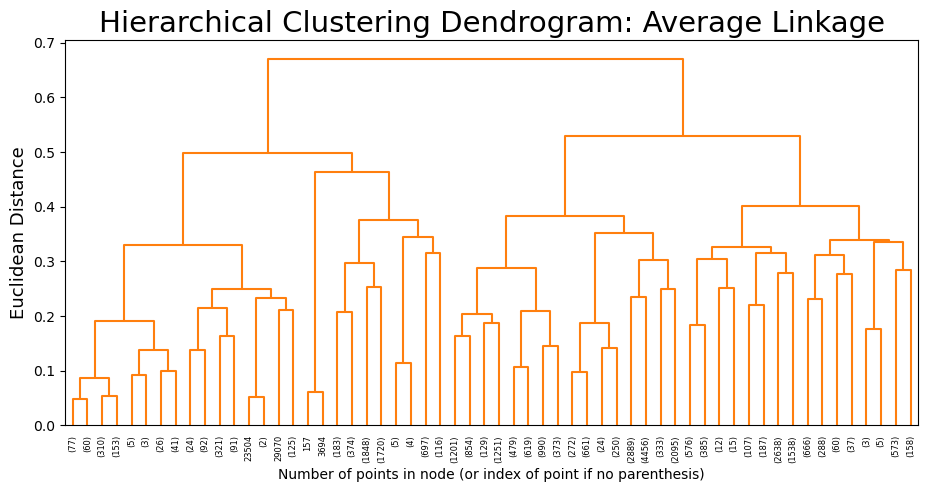

In [155]:

link = 'average'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=link, metric=distance, distance_threshold=0, n_clusters=None)

hclust.fit_predict(df[value_cols])

counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)
for i, merge in enumerate(hclust.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1 
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count
linkage_matrix = np.column_stack([hclust.children_, hclust.distances_, counts]).astype(float)

fig = plt.figure(figsize=(11,5))
y_threshold = 165
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram: {link.title()} Linkage', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()




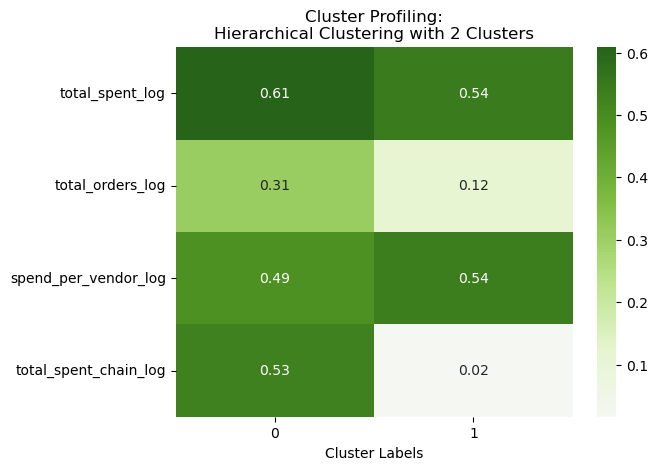

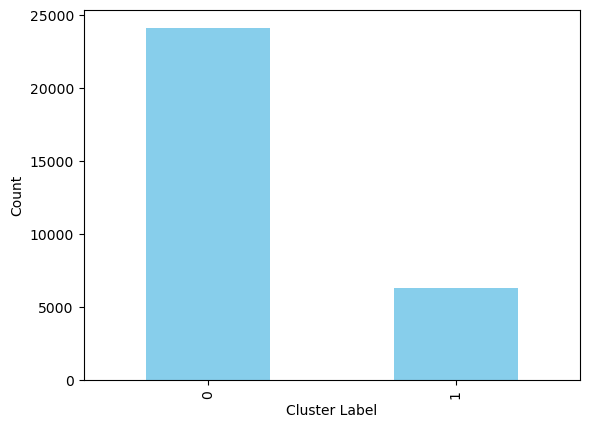

In [200]:

hc_clust = AgglomerativeClustering(n_clusters=2, linkage="average", metric="euclidean")
hc_labels = hc_clust.fit_predict(df[value_cols])


df_concat = pd.concat((df[value_cols], pd.Series(hc_labels, name='labels', index=df.index)), axis=1)

sns.heatmap(df_concat.groupby('labels')[value_cols].mean().T, center=0, annot=True, cmap="PiYG", fmt=".2f")
plt.xlabel("Cluster Labels")
plt.title("Cluster Profiling:\nHierarchical Clustering with 2 Clusters")
plt.show()

df_concat['labels'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Cluster Label')
plt.ylabel('Count')
plt.show()

In [201]:
r2_all = []
r2 = get_rsq(df_concat, value_cols, 'labels')
r2_all.append(r2)
r2

0.3428040948548586

# KMeans

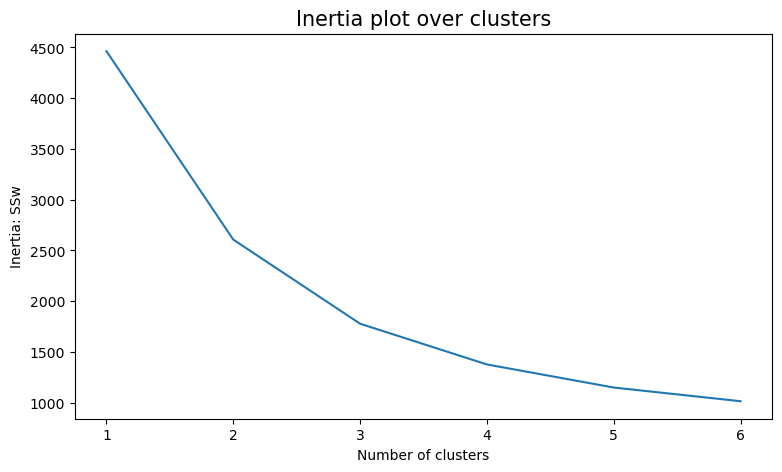

In [158]:
range_clusters = range(1, 7)
inertia = []

for n_clus in range_clusters:
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=42)
    kmclust.fit(df[value_cols])
    inertia.append(kmclust.inertia_)

fig, ax = plt.subplots(figsize=(9,5))
ax.plot(range_clusters, inertia)
ax.set_xticks(range_clusters)
ax.set_ylabel("Inertia: SSw")
ax.set_xlabel("Number of clusters")
ax.set_title("Inertia plot over clusters", size=15)
plt.show()


In [159]:
from sklearn.metrics import silhouette_score, silhouette_samples
from matplotlib import cm

avg_silhouette = []

for nclus in range_clusters:
    if nclus == 1:
        continue

    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=42)
    cluster_labels = kmclust.fit_predict(df[value_cols])

    silhouette_avg = silhouette_score(df[value_cols], cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")


For n_clusters = 2, the average silhouette_score is : 0.34839117090289273
For n_clusters = 3, the average silhouette_score is : 0.3824793285759388
For n_clusters = 4, the average silhouette_score is : 0.3510784667249986
For n_clusters = 5, the average silhouette_score is : 0.3435297267454086
For n_clusters = 6, the average silhouette_score is : 0.33331050007756674


<Figure size 1300x700 with 0 Axes>

<Figure size 1300x700 with 0 Axes>

<Figure size 1300x700 with 0 Axes>

<Figure size 1300x700 with 0 Axes>

<Figure size 1300x700 with 0 Axes>

In [160]:
kmclust = KMeans(n_clusters=3, init='k-means++', n_init=15, random_state=42)
km_labels = kmclust.fit_predict(df[value_cols])

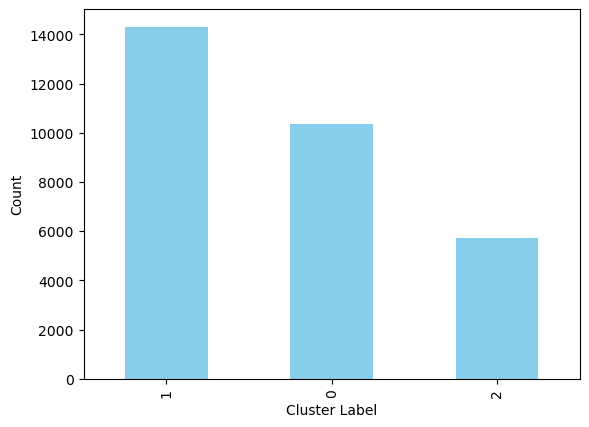

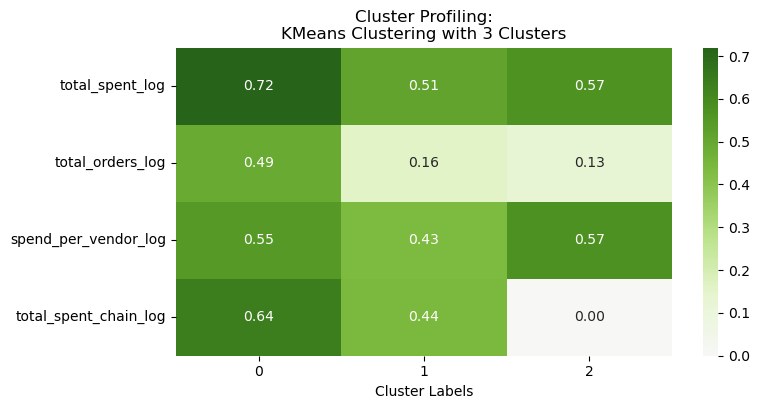

In [161]:
df_concat = pd.concat((df[value_cols], pd.Series(km_labels, name='labels', index=df.index)), axis=1)

df_concat['labels'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Cluster Label')
plt.ylabel('Count')

fig, ax = plt.subplots(figsize=(8,4))
km_profile = df_concat.groupby('labels').mean().T
sns.heatmap(km_profile,
            center=0, annot=True, cmap="PiYG", fmt=".2f",
            ax=ax)
ax.set_xlabel("Cluster Labels")
ax.set_title("Cluster Profiling:\nKMeans Clustering with 3 Clusters")
plt.show()


In [162]:
r2 = get_rsq(df_concat, value_cols, 'labels')
r2_all.append(r2)
r2

0.6014814456162794

# SOM (Emergent SOM)

In [163]:

neigh = 'gaussian'
topol = 'hexagonal'
n_feats = len(value_cols)
activation_distc = 'euclidean'

som_data = df[value_cols].values

In [164]:
from numpy.linalg import eig


cov_matrix = np.cov(df[value_cols].T)

eigenvalues, _ = eig(cov_matrix)
eigenvalues = sorted(eigenvalues.round(3), reverse=True)
ratio = eigenvalues[0] / eigenvalues[1]
ratio.round(2)

3.07

In [165]:
grid_size = 4_000 
M = np.sqrt(grid_size * ratio).round().astype(int)
N = (grid_size / M).round().astype(int)
print(f"M: {M}, N: {N}")

M: 111, N: 36


In [166]:

n_feats = len(value_cols)

learning_rates = [0.5] # 0.3, 0.6 
sigmas = [3] # 1, 1.5, 2, 2.5
epochs_list = [500_000]

som_data = df[value_cols].values

best_te = float('inf')
best_params = {}

for lr in learning_rates:
    for sigma in sigmas:
        sm = MiniSom(M, N, n_feats, sigma=sigma, learning_rate=lr, neighborhood_function=neigh, topology=topol, random_seed=42, activation_distance=activation_distc)
        sm.random_weights_init(som_data)
        
        print(f"Pre training QE: {sm.quantization_error(som_data)}")
        print(f"Pre training TE: {sm.topographic_error(som_data)}")
        
        sm.train_batch(som_data, epochs_list[0])

        qe = sm.quantization_error(som_data)
        te = sm.topographic_error(som_data)

        print(f"LR: {lr}, Sigma: {sigma}, Epochs: {epochs_list[0]} -> QE: {qe:.3f}, TE: {te:.3f}")

        # Update best parameters based on TE
        if te < best_te:
            best_te = te
            best_params = {'learning_rate': lr, 'sigma': sigma, 'epochs': epochs_list[0]}


best_params

c:\Users\gaspa\anaconda3\envs\DM2425\Lib\site-packages\minisom.py:631: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


Pre training QE: 0.010955207848320178
Pre training TE: 0.9986515375760566
LR: 0.5, Sigma: 3, Epochs: 500000 -> QE: 0.016, TE: 0.095


{'learning_rate': 0.5, 'sigma': 3, 'epochs': 500000}

In [167]:
sm = MiniSom(M, N, n_feats, sigma=3, learning_rate=0.5, neighborhood_function=neigh, topology=topol, random_seed=42, activation_distance=activation_distc)

sm.random_weights_init(som_data)

print("Before training:")
print(f"QE: {sm.quantization_error(som_data).round(3)}")
print(f"TE: {sm.topographic_error(som_data).round(3)}")

sm.train_batch(som_data, 500_000)

print("After training:")
print(f"QE: {sm.quantization_error(som_data).round(3)}")
print(f"TE: {sm.topographic_error(som_data).round(3)}")


Before training:
QE: 0.011
TE: 0.999
After training:
QE: 0.016
TE: 0.095


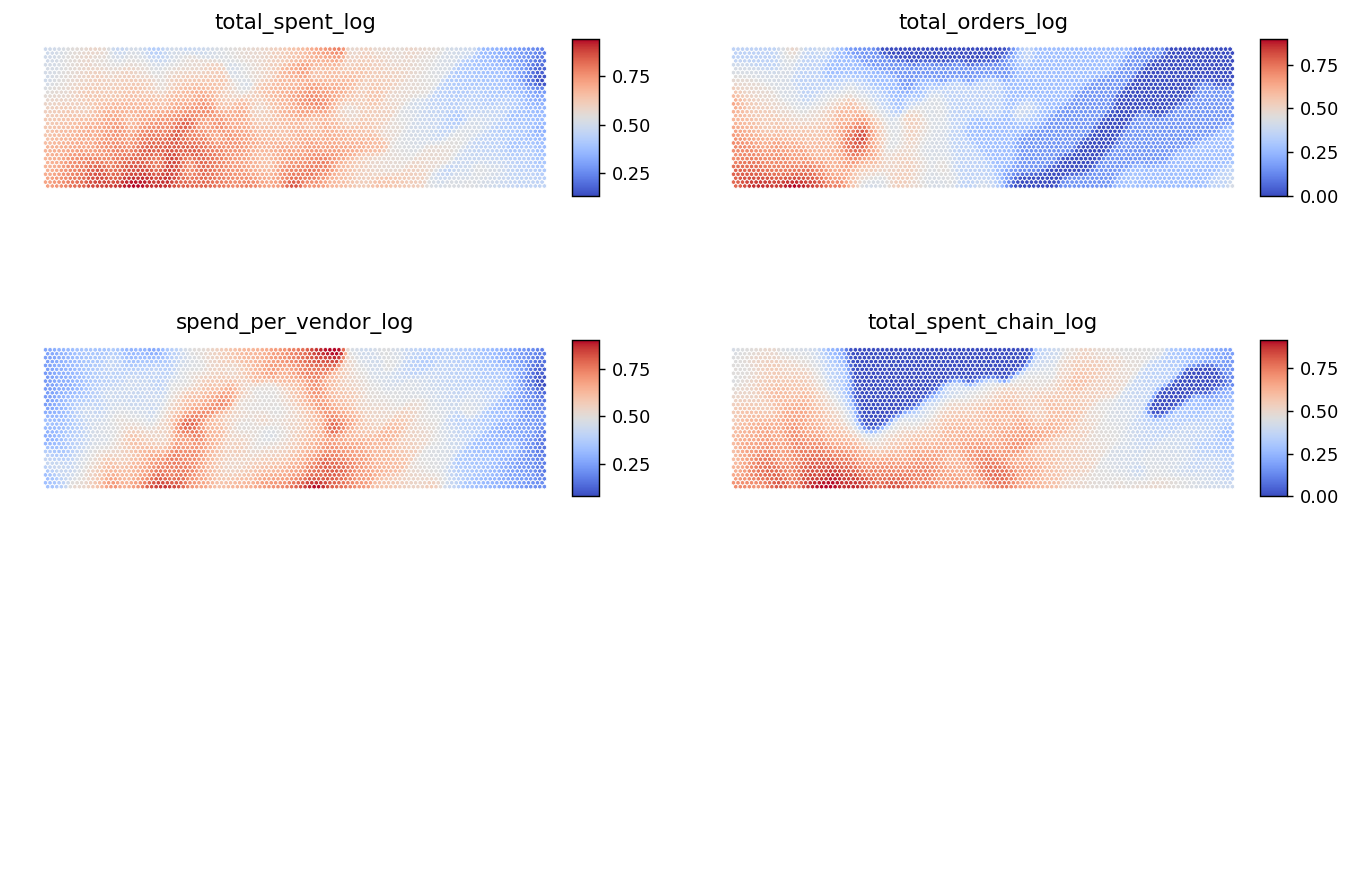

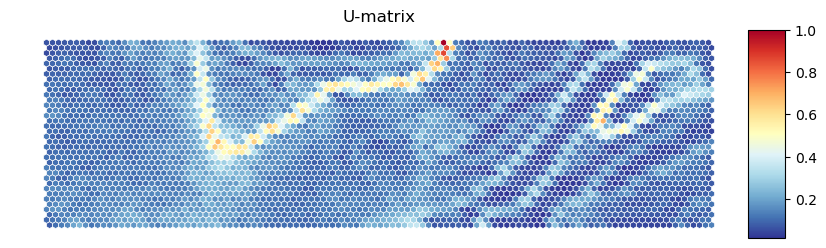

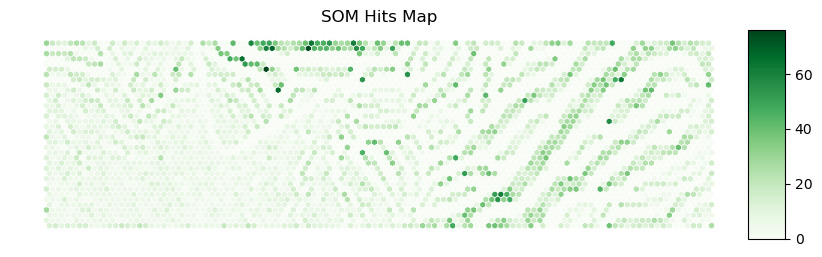

In [169]:
weights = sm.get_weights()
weights.shape
figsize=(10,7)
fig = plt.figure(figsize=figsize, constrained_layout=True, dpi=128, )
subfigs = fig.subfigures(3,2,wspace=.15)
colornorm = mpl_colors.Normalize(vmin=np.min(weights), vmax=np.max(weights))
for cpi, sf in zip(range(len(value_cols)), subfigs.flatten()):
    matrix_vals = weights[:,:,cpi]
    vext = np.max(np.abs([np.min(matrix_vals), np.max(matrix_vals)]))
    colornorm = mpl_colors.Normalize(vmin=np.min(matrix_vals), vmax=np.max(matrix_vals))
    #colornorm = mpl_colors.CenteredNorm(vcenter=0, halfrange=vext)
    sf = plot_hexagons(sm, sf, 
                    colornorm,
                    matrix_vals,
                    label=value_cols[cpi],
                    cmap=cm.coolwarm,
                    )
    
    
umatrix = sm.distance_map(scaling='mean')
fig = plt.figure(figsize=figsize)
colornorm = mpl_colors.Normalize(vmin=np.min(umatrix), vmax=np.max(umatrix))
fig = plot_hexagons(sm, fig, 
                    colornorm,
                    umatrix,
                    label="U-matrix",
                    cmap=cm.RdYlBu_r,
                    )


hitsmatrix = sm.activation_response(df[value_cols].values)
fig = plt.figure(figsize=figsize)
colornorm = mpl_colors.Normalize(vmin=0, vmax=np.max(hitsmatrix))
fig = plot_hexagons(sm, fig, 
                    colornorm,
                    hitsmatrix,
                    label="SOM Hits Map",
                    cmap=cm.Greens,
                    )

In [170]:
weights_flat = sm.get_weights().reshape((M*N),len(value_cols))
weights_flat.shape

(3996, 4)

# KMeans on SOM

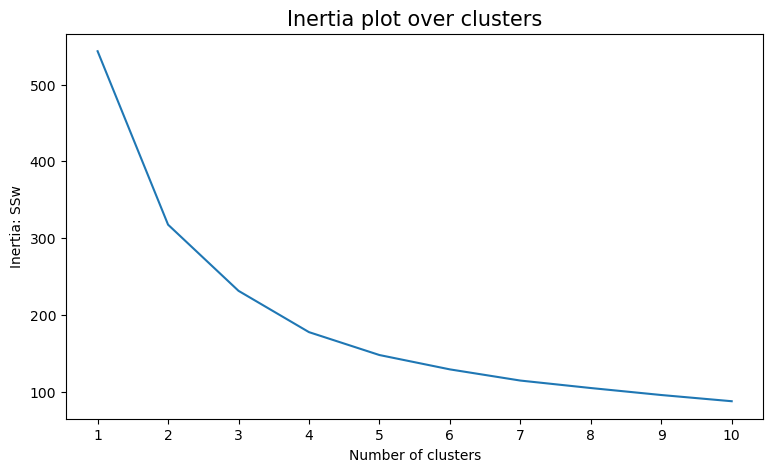

In [182]:

range_clusters = range(1, 11)
inertia = []
for n_clus in range_clusters:  
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=42)
    kmclust.fit(weights_flat)
    inertia.append(kmclust.inertia_)
    
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(range_clusters, inertia)
ax.set_xticks(range_clusters)
ax.set_ylabel("Inertia: SSw")
ax.set_xlabel("Number of clusters")
ax.set_title("Inertia plot over clusters", size=15)
plt.show()

In [181]:
avg_silhouette = []
for nclus in range_clusters:
    if nclus == 1:
        continue

    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=42)
    cluster_labels = kmclust.fit_predict(weights_flat)

    silhouette_avg = silhouette_score(weights_flat, cluster_labels, metric='euclidean')
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

For n_clusters = 2, the average silhouette_score is : 0.3489545023655526
For n_clusters = 3, the average silhouette_score is : 0.3608350574633661
For n_clusters = 4, the average silhouette_score is : 0.3328284573938444
For n_clusters = 5, the average silhouette_score is : 0.32446825090208276
For n_clusters = 6, the average silhouette_score is : 0.3102183992785126
For n_clusters = 7, the average silhouette_score is : 0.3102393691382816
For n_clusters = 8, the average silhouette_score is : 0.30352051924203044
For n_clusters = 9, the average silhouette_score is : 0.2923481280678005
For n_clusters = 10, the average silhouette_score is : 0.29079844175166497


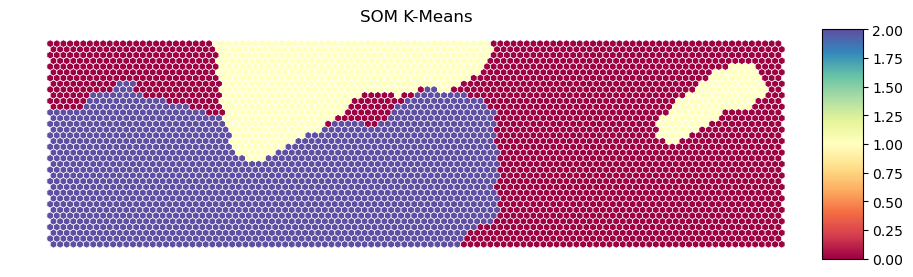

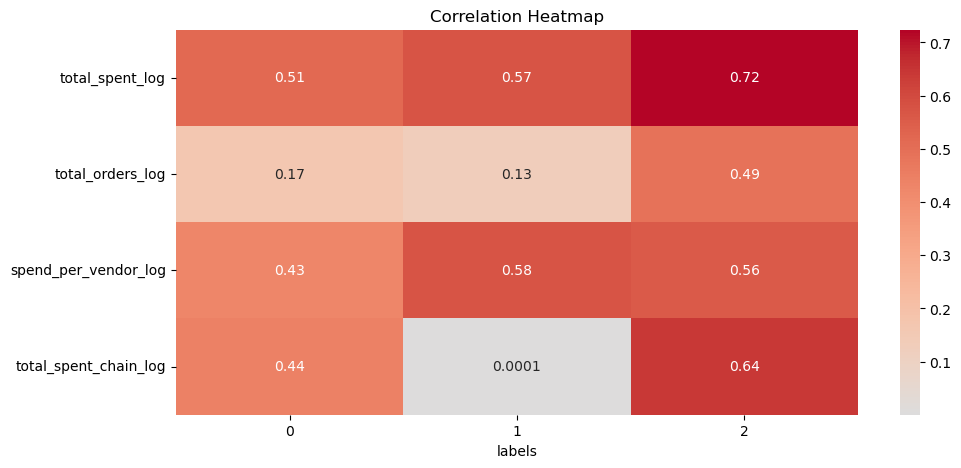

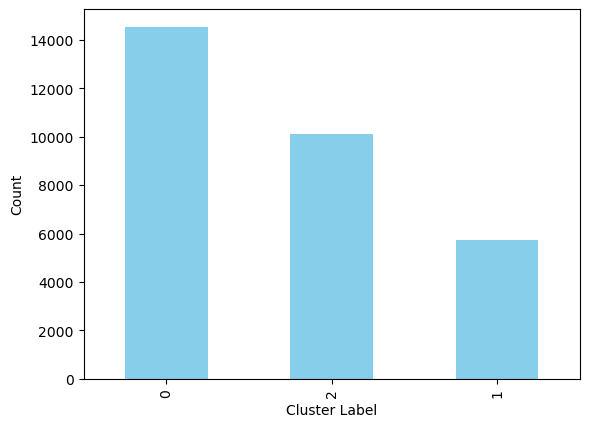

In [173]:

kmeans = KMeans(n_clusters=3, init='k-means++', n_init=20, random_state=42)

nodeclus_labels = kmeans.fit_predict(weights_flat)

kmeans_matrix = nodeclus_labels.reshape((M,N))

fig = plt.figure(figsize=(11,5))
colornorm = mpl_colors.Normalize(vmin=0, vmax=np.max(kmeans_matrix))
fig = plot_hexagons(sm, fig, 
                    colornorm,
                    kmeans_matrix,
                    label="SOM K-Means",
                    cmap=cm.Spectral,
                    )


nodes = weights_flat
df_nodes = pd.DataFrame(nodes, columns=value_cols)
df_nodes['label'] = nodeclus_labels

# shape df.shape[0], 2 dimension 
bmu_index = np.array([sm.winner(x) for x in df[value_cols].values])
som_final_labels = [kmeans_matrix[i[0]][i[1]] for i in bmu_index]

fig = plt.figure(figsize=(11,5))
df_concat = pd.concat((df[value_cols], pd.Series(som_final_labels, name='labels', index=df.index)), axis=1)
sns.heatmap(df_concat.groupby("labels").mean().T, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

df_concat['labels'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Cluster Label')
plt.ylabel('Count')
plt.show()

In [174]:
r2 = get_rsq(df_concat, value_cols, 'labels')
r2_all.append(r2)
r2

0.6001844375287018

# Hierarchical on SOM

C:\Users\gaspa\AppData\Local\Temp\ipykernel_35196\2219672209.py:14: UserWarning: The markers list has more values (4) than needed (3), which may not be intended.
  sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)


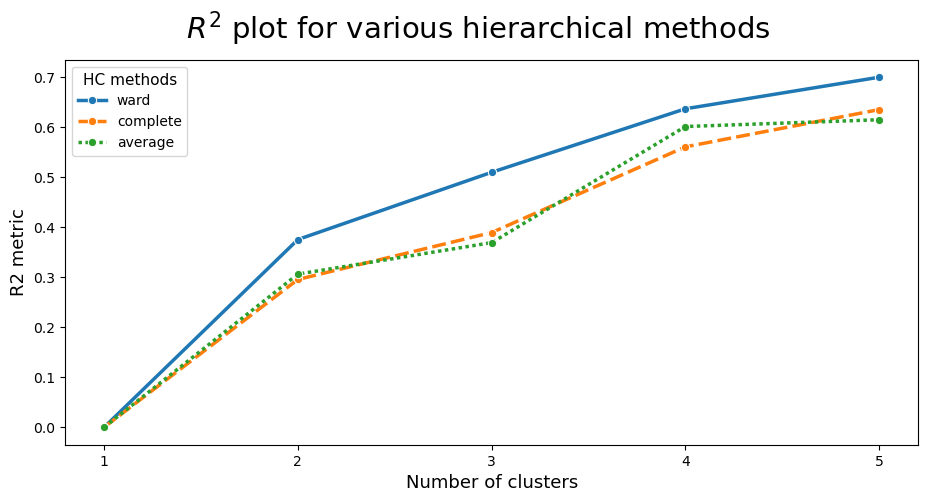

In [175]:
weights_flat = pd.DataFrame(weights_flat, columns=value_cols)

hc_methods = ["ward", "complete", "average"] #r2
max_nclus = 5
r2_hc = np.vstack([ get_r2_hc(weights_flat,
                              link,
                              max_nclus=max_nclus,
                              min_nclus=1,
                              dist="euclidean")
                              for link in hc_methods])

r2_hc_methods = pd.DataFrame(r2_hc.T, index=range(1, max_nclus + 1), columns=hc_methods)
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)
fig.suptitle("$R^2$ plot for various hierarchical methods", fontsize=21)
plt.show()

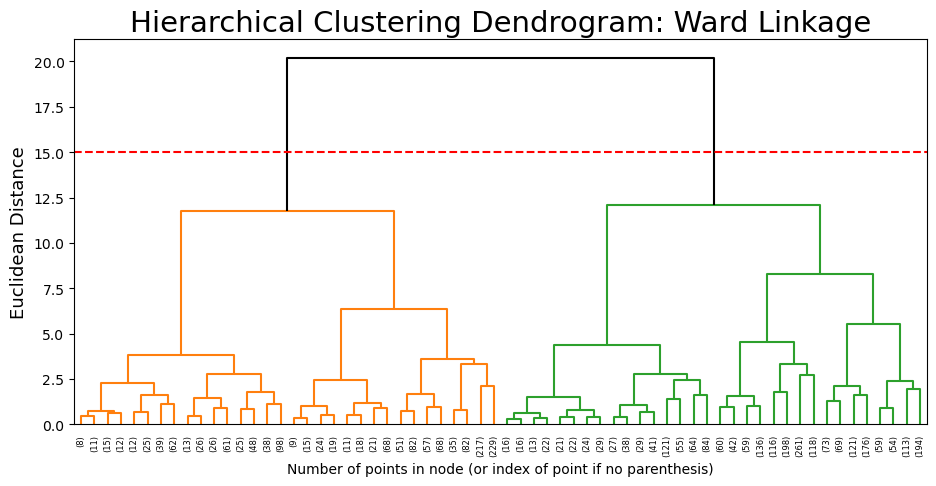

In [185]:
link = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=link, metric=distance, distance_threshold=0, n_clusters=None)

hclust.fit_predict(weights_flat)

counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)
for i, merge in enumerate(hclust.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1 
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count
linkage_matrix = np.column_stack([hclust.children_, hclust.distances_, counts]).astype(float)

fig = plt.figure(figsize=(11,5))
y_threshold = 15
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram: {link.title()} Linkage', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()


In [186]:
avg_silhouette = []
for nclus in range_clusters:
    if nclus == 1:
        continue

    hc = AgglomerativeClustering(linkage="ward", metric="euclidean", n_clusters=nclus)
    hc_clust = hc.fit_predict(weights_flat)

    silhouette_avg = silhouette_score(weights_flat, hc_clust, metric='euclidean')
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

For n_clusters = 2, the average silhouette_score is : 0.3293498154789017
For n_clusters = 3, the average silhouette_score is : 0.2582789504816124
For n_clusters = 4, the average silhouette_score is : 0.2910131034658329
For n_clusters = 5, the average silhouette_score is : 0.284435506868868
For n_clusters = 6, the average silhouette_score is : 0.27869040746046714
For n_clusters = 7, the average silhouette_score is : 0.2698630421606857
For n_clusters = 8, the average silhouette_score is : 0.2537295983274252
For n_clusters = 9, the average silhouette_score is : 0.2538199646622413
For n_clusters = 10, the average silhouette_score is : 0.2354603242445323


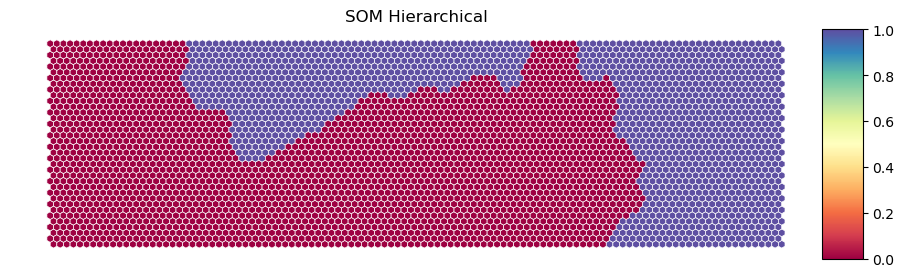

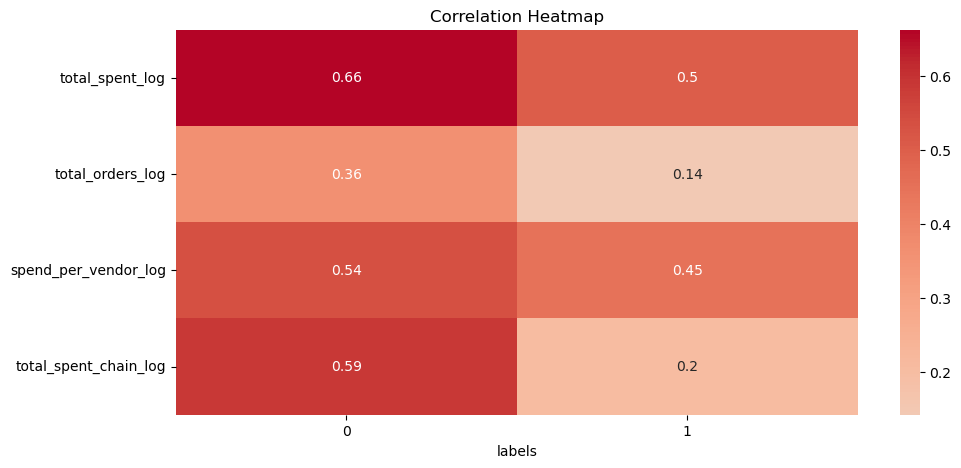

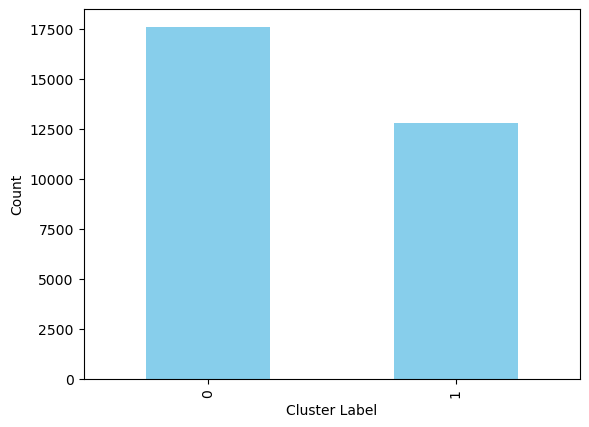

In [187]:

hc_clust = AgglomerativeClustering(n_clusters=2, linkage="ward", metric="euclidean")
nodeclus_labels = hc_clust.fit_predict(weights_flat)

hclust_matrix = nodeclus_labels.reshape((M,N))

fig = plt.figure(figsize=(11,5))
colornorm = mpl_colors.Normalize(vmin=0, vmax=np.max(hclust_matrix))
fig = plot_hexagons(sm, fig, 
                    colornorm,
                    hclust_matrix,
                    label="SOM Hierarchical",
                    cmap=cm.Spectral,
                    )



nodes = weights_flat
df_nodes = pd.DataFrame(nodes, columns=value_cols)
df_nodes['label'] = nodeclus_labels

bmu_index = np.array([sm.winner(x) for x in df[value_cols].values])

som_final_labels = [hclust_matrix[i[0]][i[1]] for i in bmu_index]

fig = plt.figure(figsize=(11,5))
df_concat = pd.concat((df[value_cols], pd.Series(som_final_labels, name='labels', index=df.index)), axis=1)
sns.heatmap(df_concat.groupby("labels").mean().T, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()


df_concat['labels'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Cluster Label')
plt.ylabel('Count')
plt.show()

In [188]:
r2 = get_rsq(df_concat, value_cols, 'labels')
r2_all.append(r2)
r2

0.37868333742545957

# Gaussian Mixture Model

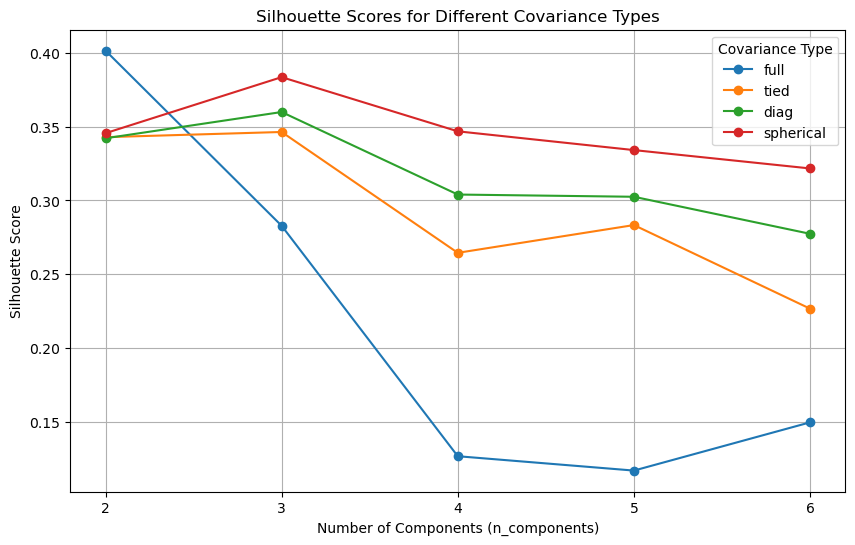

In [180]:
n_components = np.arange(2, 7)  
cov_types = ['full', 'tied', 'diag', 'spherical']  
scores = {cova: [] for cova in cov_types}  


for cova in cov_types:
    for n in n_components:
        model = GaussianMixture(n_components=n, covariance_type=cova, n_init=10, init_params='kmeans', random_state=42)
        model.fit(df[value_cols]) 
        
        gm_labels = model.predict(df[value_cols])
        
        score = silhouette_score(df[value_cols], gm_labels, metric='euclidean', random_state=42)
        scores[cova].append(score) 

plt.figure(figsize=(10, 6))
for cova in cov_types:
    plt.plot(n_components, scores[cova], marker='o', label=f'{cova}')

plt.title('Silhouette Scores for Different Covariance Types')
plt.xlabel('Number of Components (n_components)')
plt.ylabel('Silhouette Score')
plt.xticks(n_components)
plt.legend(title='Covariance Type')
plt.grid(True)
plt.show()


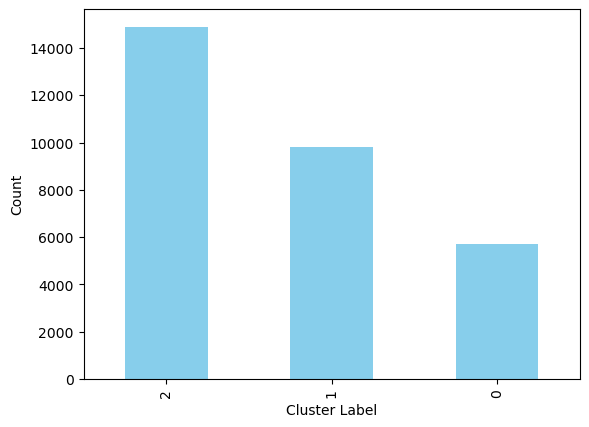

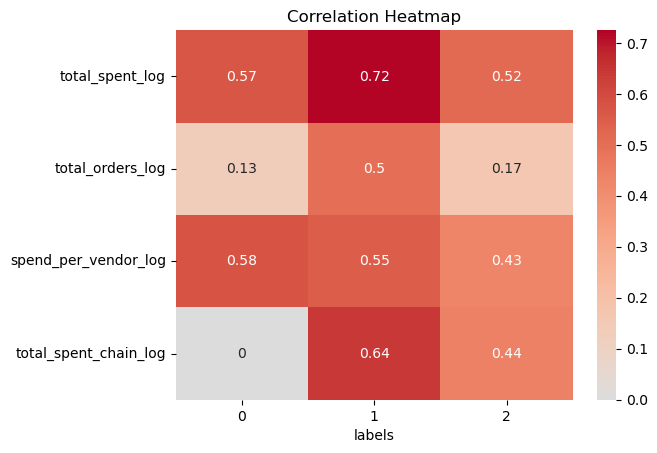

In [194]:

gm = GaussianMixture(n_components=3, covariance_type='spherical', n_init=10, init_params='kmeans', random_state=42)
gm_labels = gm.fit_predict(df[value_cols])

df_concat = pd.concat((df[value_cols], pd.Series(gm_labels, name='labels', index=df.index)), axis=1)

df_concat['labels'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Cluster Label')
plt.ylabel('Count')
plt.show()

sns.heatmap(df_concat.groupby("labels").mean().T, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()


In [195]:
r2 = get_rsq(df_concat, value_cols, 'labels')
r2_all.append(r2)
r2

0.6005103319073133

In [202]:
r2_all

[0.3428040948548586]

# Comparison of Clustering Methods for Value-Behavior

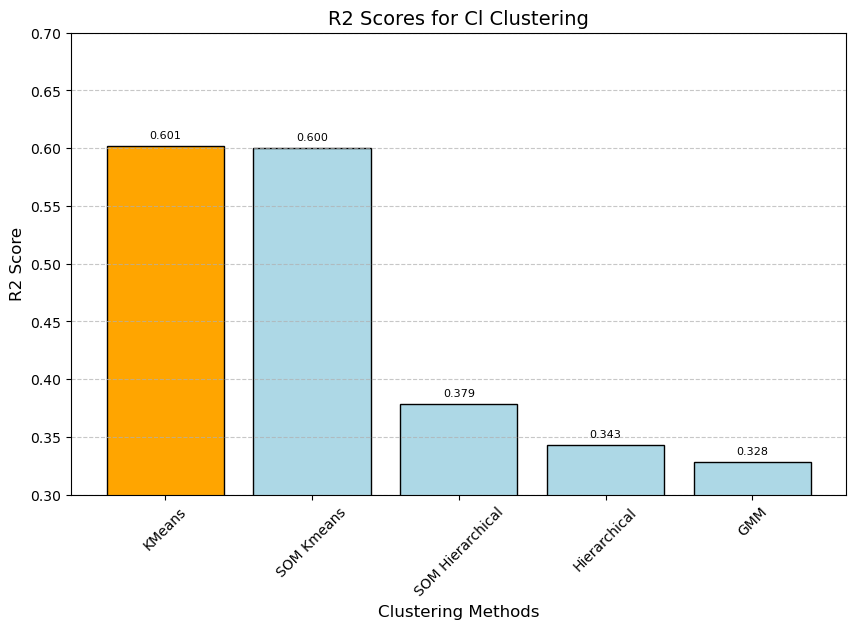

In [193]:

plt.figure(figsize=(10, 6))
methods = ['Hierarchical', 'KMeans', 'SOM Kmeans', "SOM Hierarchical", 'GMM']

sorted_indices = np.argsort(r2_all)[::-1]
methods = [methods[i] for i in sorted_indices] 
r2_all = [r2_all[i] for i in sorted_indices] 


bars = plt.bar(methods, r2_all, color='lightblue', edgecolor='black')

max_index = r2_all.index(max(r2_all))
bars[max_index].set_color('orange')
bars[max_index].set_edgecolor('black')

for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, f'{r2_all[i]:.3f}',
             ha='center', va='bottom', fontsize=8, color='black')

plt.title('R2 Scores for Cl Clustering', fontsize=14)
plt.xlabel('Clustering Methods', fontsize=12)
plt.ylabel('R2 Score', fontsize=12)
plt.ylim(0.3, 0.7)  
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.xticks(rotation=45) 
plt.show()

# Final Solution

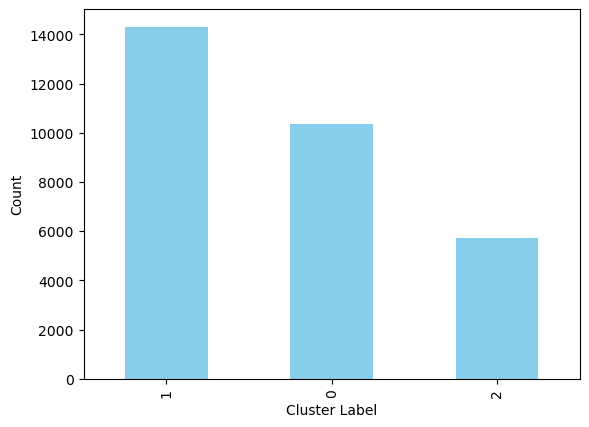

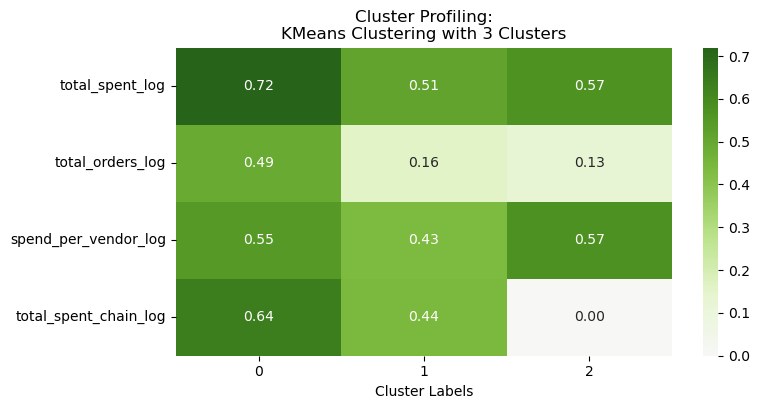

In [207]:
kmclust = KMeans(n_clusters=3, init='k-means++', n_init=15, random_state=42)
km_labels = kmclust.fit_predict(df[value_cols])

df_concat = pd.concat((df[value_cols], pd.Series(km_labels, name='labels', index=df.index)), axis=1)

df_concat['labels'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Cluster Label')
plt.ylabel('Count')

fig, ax = plt.subplots(figsize=(8,4))
km_profile = df_concat.groupby('labels').mean().T
sns.heatmap(km_profile,
            center=0, annot=True, cmap="PiYG", fmt=".2f",
            ax=ax)
ax.set_xlabel("Cluster Labels")
ax.set_title("Cluster Profiling:\nKMeans Clustering with 3 Clusters")
plt.show()

In [208]:
r2 = get_rsq(df_concat, value_cols, 'labels')
r2

0.6014814456162794